In [ ]:
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

# Core configuration & plotting settings
from qspectro2d.config import *  # provides CONFIG and mpl settings

# Updated spectroscopy calculation imports
from qspectro2d.spectroscopy.calculations import (
    parallel_compute_1d_E_with_inhomogenity,
    compute_1d_polarization,
    extract_ift_signal_component,
)
from qspectro2d.spectroscopy import compute_2d_fft_wavenumber

# Visualization (updated centralized helpers)
from qspectro2d.visualization import (
    plot_example_evo,
    plot_example_polarization,
    plot_2d_el_field,
)

# Utilities (updated path after refactor)
from qspectro2d.utils import (
    save_data_file,
    save_info_file,
    generate_unique_data_filename,
)
from qspectro2d.config import create_base_sim_oqs

# Core simulation + system components (new module locations)
from qspectro2d.core.simulation import SimulationConfig, SimulationModuleOQS
from qspectro2d.core.atomic_system.system_class import AtomicSystem
from qspectro2d.core.laser_system.laser_class import LaserPulseSequence
from qspectro2d.core.simulation.redfield_paper import redfield_paper


def run_single_t_coh_with_sim(
    sim_oqs: SimulationModuleOQS,
    t_coh: float,
    save_info: bool = False,
    time_cut: float = -np.inf,
) -> Path:
    """
    Run a single 1D simulation for a specific coherence time using existing SimulationModuleOQS.

    Parameters:
        sim_oqs (SimulationModuleOQS): Pre-configured simulation instance
        t_coh (float): Coherence time between 2 pump pulses [fs]
        save_info (bool): Whether to save simulation info
        time_cut (float): Time cutoff for solver validation

    Returns:
        Path: absolute path to the saved data directory
    """
    print(f"\n=== Starting t_coh = {t_coh:.2f} fs ===")

    # Update t_coh in the simulation config
    sim_oqs.simulation_config.t_coh = t_coh
    t_wait = sim_oqs.simulation_config.t_wait
    sim_oqs.laser.update_delays = [t_coh, t_wait]

    start_time = time.time()

    # Run the simulation
    print("Computing 1D polarization with parallel processing...")
    try:
        data = parallel_compute_1d_E_with_inhomogenity(
            sim_oqs=sim_oqs,
            time_cut=time_cut,
        )
        print("✅ Parallel computation completed successfully!")
    except Exception as e:
        print(f"❌ ERROR: Simulation failed: {e}")
        raise

    # Save data
    simulation_config_dict = sim_oqs.simulation_config.to_dict()
    abs_path = Path(
        generate_unique_data_filename(sim_oqs.system, simulation_config_dict)
    )
    abs_data_path = Path(f"{abs_path}_data.npz")
    print(f"\nSaving data to: {abs_data_path}")

    save_data_file(abs_data_path, data, sim_oqs.times_det)

    if save_info:
        abs_info_path = Path(f"{abs_path}_info.pkl")
        save_info_file(
            abs_info_path,
            sim_oqs.system,
            bath=sim_oqs.bath,
            laser=sim_oqs.laser,
            info_config=simulation_config_dict,
        )

        print(f"{'='*60}")
        print(f"\n🎯 To plot this data, run:")
        print(f'python plot_datas.py --abs_path "{abs_path}"')

    elapsed_time = time.time() - start_time
    print(f"Total execution time: {elapsed_time:.2f} seconds")

    return abs_path

In [5]:
from types import SimpleNamespace
from qutip import bloch_redfield_tensor, QobjEvo
t_coh = 5.0
args = SimpleNamespace(t_coh=t_coh, t_wait=0.0, t_det_max=10.0, dt=0.5)
sim_oqs, time_cut = create_base_sim_oqs(args)

H = sim_oqs.H0_diagonalized
H_int_method = sim_oqs.H_int_sl  # This is a method that takes time as parameter

# Call the method at time=0 to get the actual Hamiltonian
t = t_coh  # time parameter
H_int = H_int_method(t)  # Now this is a Qobj

# Now you can add them together
total_H = H + H_int
print("Total Hamiltonian at t=t_coh:")
print(total_H)

# For Bloch-Redfield tensor, you typically need the static part
R_t = bloch_redfield_tensor(total_H, sim_oqs.decay_channels)
print(R_t[0].tidyup())

🔧 Creating base simulation configuration...
🔎 Validating configuration...
🔍 Validating solver...


c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)
Total Hamiltonian at t=t_coh:
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.         -0.54322623 -0.54322623  0.        ]
 [-0.54322623 -0.01883699  0.         -0.54322623]
 [-0.54322623  0.          0.         -0.54322623]
 [ 0.         -0.54322623 -0.54322623 -0.01883699]]
Quantum object: dims=[[[4], [4]], [[4], [4]]], shape=(16, 16), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00-9.41707946e-03j
   0.00000000e+00-9.41849478e-03j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+9.41707946e-03j  9.44990782e-07+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+9.41849478e-03j  0.00000000e+00+0.00000000e+00j
   9.40392157e-07+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00

In [3]:
args = SimpleNamespace(t_coh=t_coh, t_wait=0.0, t_det_max=10.0, dt=0.5)
sim_oqs, time_cut = create_base_sim_oqs(args)

H = sim_oqs.H0_diagonalized
H_int_method = sim_oqs.H_int_sl  # This is a method that takes time as parameter

# Call the method at time=0 to get the actual Hamiltonian
t = 0  # time parameter
H_int = H_int_method(t)  # Now this is a Qobj

# Now you can add them together
total_H = H + H_int
R_0 = bloch_redfield_tensor(total_H, sim_oqs.decay_channels)
print(R_0[0])
print(R_t[0][1])
print(R_0[0][1])


🔧 Creating base simulation configuration...
🔎 Validating configuration...
🔍 Validating solver...
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)
Quantum object: dims=[[[4], [4]], [[4], [4]]], shape=(16, 16), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 0.00000000e+00+1.36702564e-18j  0.00000000e+00-9.41679959e-03j
   0.00000000e+00-9.41849478e-03j  0.00000000e+00-8.70687896e-17j
   0.00000000e+00+9.41679959e-03j  8.64652222e-07-4.90249590e-18j
   0.00000000e+00-1.38590105e-17j  0.00000000e+00+1.14785327e-17j
   0.00000000e+00+9.41849478e-03j  0.00000000e+00+5.86512309e-18j
   8.60055147e-07+4.09749743e-19j  0.00000000e+00-9.64204421e-18j
   0.00000000e+00+8.07810735e-17j  0.00000000e+00-4.77495467e-18j
   0.00000000e+00+2.93661976e-18j  7.30042720e-07-7.49503593e-18j]
 [ 0.00000000e+00-9.41679959e-03j -4.33459792e-07+9.92523791e-01j
   0.00000000e+00-1.16400044e-13j  0.00000000e+00-9.418494

In [4]:
from project_config import SCRIPTS_DIR
cfg_path = SCRIPTS_DIR / "config.yaml"
cfg = load_config(cfg_path)
sim_oqs_paper, _ = create_base_sim_oqs(args, cfg=cfg)
redfield_paper(sim_oqs_paper)

🔧 Creating base simulation configuration...
🔎 Validating configuration...
🔍 Validating solver...


c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: divide by zero encountered in divide
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


KeyboardInterrupt: 

In [ ]:
import qutip
from qspectro2d.core.bath_system import extract_bath_parameters
print(isinstance(sim_oqs.bath, qutip.BosonicEnvironment))
w0 = sim_oqs.system.frequencies[0]
print(extract_bath_parameters(sim_oqs.bath, w0=w0))

True
{'T': 0.0029950813385969796, 'tag': 'ohmic', 'S(0)': 5.990162677193959e-09, 'S(w0)': 5.930559562686351e-06, 'alpha': 1e-06, 'wc': 299.508133859698, 's': 1.0}


c:\Users\leopo\anaconda3\envs\master_env\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


deph_rate_pure: 0.01, down_rate: 9.900498337491682, up_rate: -0.0, coupling: 1.6694037439204263


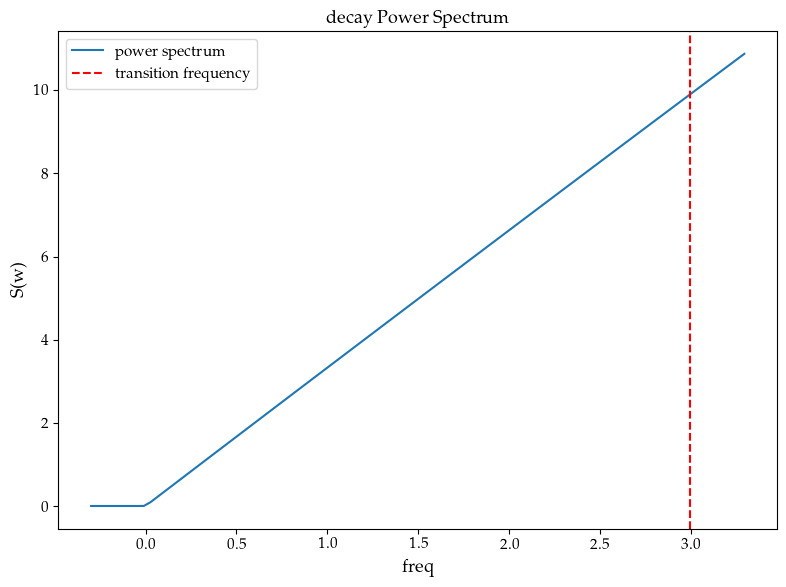

In [ ]:
# Rates
gamma_phi = 1 / 100
w0 = sim_oqs.system.frequencies[0]  # transition frequency
from qspectro2d.core.bath_system.bath_fcts import rates_to_alpha, bath_to_rates
alpha = rates_to_alpha(gamma_phi, sim_oqs.bath, w0, mode="deph")
sim_oqs.bath.alpha = alpha  # set the alpha in the bath
deph_rate_pure = bath_to_rates(sim_oqs.bath, mode="deph")  # pure dephasing rate
down_rate, up_rate = bath_to_rates(
    sim_oqs.bath, w0, mode="decay"
)  # emission, absorption
S= sim_oqs.bath.power_spectrum
w_max = sim_oqs.bath.wc  # maximum frequency for the power spectrum
w = np.linspace(-w0/10, 1.1*w0, 100)  # frequency range for the power spectrum

plt.figure()
plt.plot(w, S(w), label='power spectrum')
# plot vertical line at w0
plt.axvline(w0, color='red', linestyle='--', label='transition frequency')
plt.xlabel('freq')
plt.ylabel('S(w)')
plt.title('decay Power Spectrum')
plt.legend()

print(f"deph_rate_pure: {deph_rate_pure}, down_rate: {down_rate}, up_rate: {up_rate}, coupling: {sim_oqs.bath.alpha}")


0.5 0.25
(Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 0.        +0.00000000e+00j  0.        +5.20417043e-17j
   0.        -5.20417043e-17j  0.24514517+0.00000000e+00j]
 [ 0.        +1.10154941e-16j -0.16103412-6.40761690e+00j
   0.        +1.38777878e-17j  0.        -1.11022302e-16j]
 [ 0.        -1.61329283e-16j  0.        -1.38777878e-17j
  -0.16103412+6.40761690e+00j  0.        +1.11022302e-16j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -0.24514517+0.00000000e+00j]], Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-0.99513333 -0.09853762]
 [-0.09853762  0.99513333]])


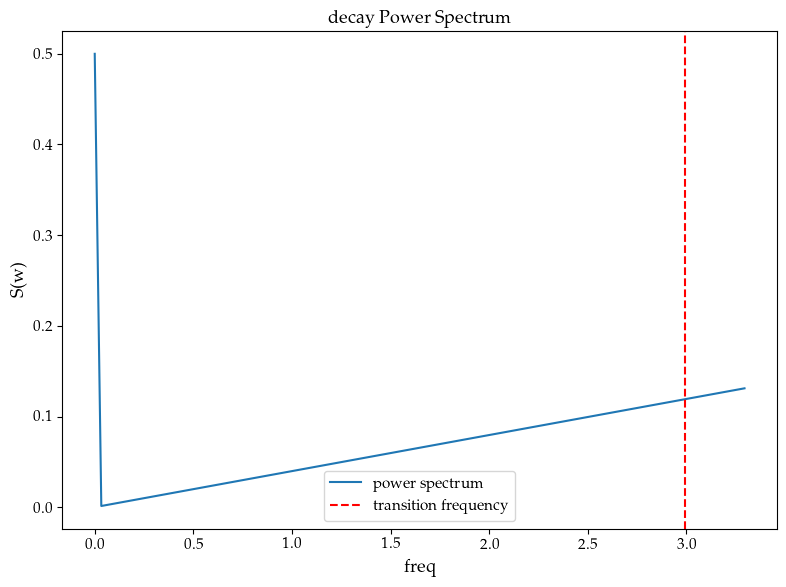

In [ ]:
from qutip import sigmax, sigmaz, mesolve, basis, brmesolve, bloch_redfield_tensor
delta = 0.2 * 2*np.pi
eps0 = 1.0 * 2*np.pi
gamma1 = 0.5

H = - delta/2.0 * sigmax() - eps0/2.0 * sigmaz()

def ohmic_spectrum(w):
  if w == 0.0: # dephasing inducing noise
    return gamma1
  else: # relaxation inducing noise
    return gamma1 / 2 * (w / (2 * np.pi)) * (w > 0.0)

g_deph = ohmic_spectrum(0.0)
g_decay = ohmic_spectrum(eps0)
print(g_deph, g_decay)
res = brmesolve(H, basis(2,0), tlist=np.linspace(0, 10, 100), c_ops=[], sec_cutoff=0.1)

w_max = eps0  # maximum frequency for the power spectrum
w = np.linspace(00, 1.1*w0, 100)  # frequency range for the power spectrum
plt.figure()
plt.plot(w, [ohmic_spectrum(x) for x in w], label='power spectrum')
# plot vertical line at w0
plt.axvline(w0, color='red', linestyle='--', label='transition frequency')
plt.xlabel('freq')
plt.ylabel('S(w)')
plt.title('decay Power Spectrum')
plt.legend()


R = bloch_redfield_tensor(H, a_ops=[[sigmax(), ohmic_spectrum],])
print(R)

In [ ]:
from types import SimpleNamespace
from qspectro2d.config import create_base_sim_oqs

args = SimpleNamespace(t_coh=5.0, t_wait=0.0, t_det_max=10.0, dt=0.5)

sim_oqs, time_cut = create_base_sim_oqs(args)
print(f"Base sim created. time_cut={time_cut:.2f}")

🔧 Creating base simulation configuration...
🔎 Validating configuration...
🔍 Validating solver...
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)
Base sim created. time_cut=inf


Transition frequency w_0: 3.0139183281479043
deph constant, S at w=0: 5.99016267719396e-11
decay constant, S at w_0: 0.01787309803258771


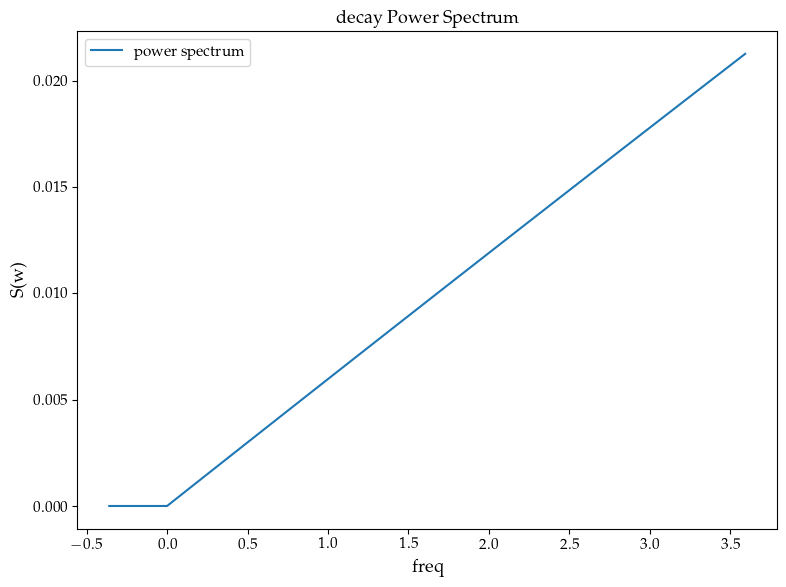

In [ ]:
from qspectro2d.core.system_bath_class import SystemBathCoupling  # updated module
from qutip import mesolve, brmesolve, basis, expect, ket2dm, OhmicEnvironment

# Build a minimal atomic system and bath using new class locations
from qspectro2d.core.atomic_system.system_class import AtomicSystem

sys = AtomicSystem(
    n_atoms=1,
    psi_ini=(basis(2, 1) + basis(2, 0)).unit(),  # initially excited superposition
)
w_0 = sys.frequencies[0]

temp = 1e-8  # Temperature in Kelvin
cutoff = 1e2 * w0  # Cutoff frequency (fs^-1)
alpha = 1e-3 * w0  # Coupling strength
bath = OhmicEnvironment(T=temp, alpha=alpha, wc=cutoff, s=1.0, tag="Ohmic Bath")

sb_coupling = SystemBathCoupling(
    system=sys,
    bath=bath,
)
S = bath.power_spectrum
S_at_w_0 = S(w_0)
S_at_0 = S(0)

print(f"Transition frequency w_0: {w_0}")
print(f"deph constant, S at w=0: {S_at_0}")
print(f"decay constant, S at w_0: {S_at_w_0}")
w = np.linspace(-0.12 * w0, 1.2 * w0, 100)  # frequency range for the power spectrum

plt.figure()
plt.plot(w, S(w), label='power spectrum')
plt.xlabel('freq')
plt.ylabel('S(w)')
plt.title('decay Power Spectrum')
plt.legend()

In [ ]:
# =============================
# DETAILED BALANCE / KMS CONDITION CHECK
# =============================
from qutip import BosonicEnvironment
def check_detailed_balance_condition(
    bath: BosonicEnvironment, 
    sb_coupling: SystemBathCoupling, 
    w_range: np.ndarray
) -> None:
    """
    Check if the power spectrum satisfies the detailed balance (KMS) condition.
    
    The KMS condition states: S(-ω) = S(ω) * exp(-ħω/kT)
    For zero temperature: S(-ω) = 0 for ω > 0
    """
    
    ### Bath parameters
    S          = bath.power_spectrum
    kT         = BOLTZMANN * bath.T  # thermal energy
    
    ### Evaluate power spectrum at positive and negative frequencies
    S_positive = np.array([S(w) for w in w_range if w > 0])
    S_negative = np.array([S(-w) for w in w_range if w > 0])
    w_positive = w_range[w_range > 0]
    
    ### Expected ratio from KMS condition
    if bath.T > 1e-10:  # finite temperature
        kms_ratio_expected = np.exp(-HBAR * w_positive / kT)
    else:  # zero temperature limit
        kms_ratio_expected = np.zeros_like(w_positive)
    
    ### Actual ratio from power spectrum
    with np.errstate(divide='ignore', invalid='ignore'):
        kms_ratio_actual = S_negative / S_positive
        kms_ratio_actual = np.where(S_positive == 0, 0, kms_ratio_actual)
    
    ### Plot comparison
    plt.figure(figsize=(12, 8))
    
    ### Power spectrum vs frequency
    plt.subplot(2, 2, 1)
    plt.plot(w_range, [S(w) for w in w_range], 
             label=r'$S(\omega)$', color='C0', linestyle='solid')
    plt.axhline(y=0, color='k', linestyle='dotted', alpha=0.5)
    plt.axvline(x=0, color='k', linestyle='dotted', alpha=0.5)
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Power Spectrum $S(\omega)$')
    plt.title(r'Bath Power Spectrum')
    plt.legend()
    
    ### KMS ratio comparison
    plt.subplot(2, 2, 2)
    plt.plot(w_positive, kms_ratio_expected, 
             label=r'Expected: $\exp(-\hbar\omega/k_BT)$', 
             color='C1', linestyle='dashed')
    plt.plot(w_positive, kms_ratio_actual, 
             label=r'Actual: $S(-\omega)/S(\omega)$', 
             color='C0', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'KMS Ratio')
    plt.title(f'KMS Condition Check ($T = {bath.T:.1e}$ K)')
    plt.legend()
    plt.yscale('log')
    
    ### Relative error
    plt.subplot(2, 2, 3)
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_error = np.abs(kms_ratio_actual - kms_ratio_expected) / np.abs(kms_ratio_expected)
        relative_error = np.where(kms_ratio_expected == 0, 
                                np.abs(kms_ratio_actual), relative_error)
    
    plt.plot(w_positive, relative_error, color='C2', linestyle='solid')
    plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
    plt.ylabel(r'Relative Error')
    plt.title(r'KMS Condition Relative Error')
    plt.yscale('log')
    
    ### Thermal occupation number
    plt.subplot(2, 2, 4)
    if bath.T > 1e-10:
        n_thermal = 1 / (np.exp(HBAR * w_positive / kT) - 1)
        plt.plot(w_positive, n_thermal, color='C3', linestyle='solid')
        plt.xlabel(r'Frequency $\omega$ [fs$^{-1}$]')
        plt.ylabel(r'Thermal Occupation $n(\omega)$')
        plt.title(f'Thermal Occupation Number ($T = {bath.T:.1e}$ K)')
    else:
        plt.text(0.5, 0.5, 'Zero Temperature\n($T \\rightarrow 0$)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Thermal Occupation Number')
    
    plt.tight_layout()
    plt.show()
    
    ### Print numerical assessment
    print(f"\n{'='*50}")
    print(f"DETAILED BALANCE / KMS CONDITION CHECK")
    print(f"{'='*50}")
    print(f"Bath temperature: {bath.T:.2e} K")
    print(f"Thermal energy kT: {kT:.2e} eV")
    
    if bath.T > 1e-10:
        max_error = np.max(relative_error[np.isfinite(relative_error)])
        mean_error = np.mean(relative_error[np.isfinite(relative_error)])
        print(f"Maximum relative error: {max_error:.2e}")
        print(f"Mean relative error: {mean_error:.2e}")
        
        if max_error < 1e-6:
            print("✅ KMS condition is satisfied (error < 1e-6)")
        elif max_error < 1e-3:
            print("⚠️  KMS condition approximately satisfied (error < 1e-3)")
        else:
            print("❌ KMS condition NOT satisfied (error > 1e-3)")
    else:
        zero_temp_satisfied = np.all(S_negative < 1e-10)
        print(f"Zero temperature condition S(-ω) ≈ 0: {zero_temp_satisfied}")
        if zero_temp_satisfied:
            print("✅ Zero temperature KMS condition satisfied")
        else:
            print("❌ Zero temperature KMS condition NOT satisfied")

# Run the check
#check_detailed_balance_condition(bath, sb_coupling, w)

In [ ]:
times, datas, sim_oqs = compute_1d_polarization(sim_oqs=sim_oqs, plot_example_evo=True)
rwa_sl = sim_oqs.simulation_config.rwa_sl
print(f"RWA_SL: {rwa_sl}")
system = sim_oqs.system
bath = sim_oqs.bath
laser = sim_oqs.laser
laser_dict = {k: v for k, v in laser.to_dict().items() if k != "pulses"}  # Exclude "pulses" key
from qspectro2d.core.bath_system.bath_fcts import extract_bath_parameters
bath_dict = extract_bath_parameters(bath)
dict_combined = {**system.to_dict(), **bath_dict, **laser_dict}
plot_example_evo(times, datas, sim_oqs.laser, rwa_sl=rwa_sl, observable_strs=sim_oqs.observable_strs, **dict_combined)

RWA_SL: True


AttributeError: 'SimulationModuleOQS' object has no attribute 'observable_strs'

In [ ]:
plot_data = compute_1d_polarization(sim_oqs, time_cut=time_cut, plot_example_polarization = True)
P_full, P_only0, P_only1, P_only2 = plot_data
times = sim_oqs.times_det

pulse_seq = sim_oqs.laser
rwa_sl = sim_oqs.simulation_config.rwa_sl
observable_strs = sim_oqs.observable_strs

plot_example_polarization(times, P_full, P_only0, P_only1, P_only2)

In [ ]:
# =============================
# TEST: extract_ift_signal_component function
# =============================

### Test the IFT signal component extraction function
print("Testing extract_ift_signal_component function...")

# Create test phase array and results matrix
phases = [0, np.pi/2, np.pi, 3*np.pi/2]  # Standard phase cycling
n_phases = len(phases)

# Create test data - simulate phase-cycled results
test_times = np.linspace(0, 50, 100)
dt_test = test_times[1] - test_times[0]

print(f"Test times shape: {test_times.shape}")
print(f"Time step dt: {dt_test:.3f}")
print(f"Number of phases: {n_phases}")

# Generate synthetic phase-cycled data
results_matrix = np.zeros((n_phases, n_phases), dtype=object)

for phi1_idx, phi_1 in enumerate(phases):
    for phi2_idx, phi_2 in enumerate(phases):
        # Create complex signal with phase-dependent amplitude
        base_signal = np.exp(1j * 0.1 * test_times)  # Base oscillation
        phase_modulation = np.exp(1j * (phi_1 + phi_2))  # Phase modulation
        
        # Add some realistic features
        envelope = np.exp(-0.02 * test_times)  # Decay envelope
        noise = 0.05 * (np.random.randn(len(test_times)) + 1j * np.random.randn(len(test_times)))
        
        results_matrix[phi1_idx, phi2_idx] = (base_signal * phase_modulation * envelope + noise)

print(f"Results matrix shape: {results_matrix.shape}")
print(f"Each element shape: {results_matrix[0, 0].shape}")

try:
    # Test different signal components
    test_components = [
        [-1, 1, 0],   # Common component in 2D spectroscopy
        [1, -1, 0],   # Another common component
        [0, 0, 0],    # Zero component (should give average)
        [1, 1, 0],    # Positive component
        [-1, -1, 0],  # Negative component
    ]
    
    for component in test_components:
        print(f"\n--- Testing component {component} ---")
        
        # Extract IFT signal component
        extracted_signal = extract_ift_signal_component(
            results_matrix=results_matrix,
            phases=phases,
            component=component
        )
        
        print(f"Extracted signal shape: {extracted_signal.shape}")
        print(f"Signal type: {type(extracted_signal)}")
        print(f"Signal dtype: {extracted_signal.dtype}")
        print(f"Max amplitude: {np.max(np.abs(extracted_signal)):.4f}")
        print(f"Mean amplitude: {np.mean(np.abs(extracted_signal)):.4f}")
        
        # Check if signal is complex
        if np.iscomplexobj(extracted_signal):
            print(f"Real part range: [{np.min(np.real(extracted_signal)):.4f}, {np.max(np.real(extracted_signal)):.4f}]")
            print(f"Imag part range: [{np.min(np.imag(extracted_signal)):.4f}, {np.max(np.imag(extracted_signal)):.4f}]")
        
        # Verify the extracted signal has the same length as input
        if len(extracted_signal) == len(test_times):
            print("✓ Output length matches input length")
        else:
            print(f"❌ Length mismatch: expected={len(test_times)}, got={len(extracted_signal)}")
    
    print(f"\n{'='*50}")
    print("✅ extract_ift_signal_component function tests completed successfully!")
    
except Exception as e:
    print(f"❌ ERROR testing extract_ift_signal_component: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()

In [ ]:

# Additional test: Test with identical data (should give zero for non-zero components)
print(f"\n--- Testing with identical data (debugging phase cycling issue) ---")
try:
    # Create test matrix where all elements are identical (simulating your issue)
    identical_signal = np.array([1+1j, 2+2j, 3+3j, 4+4j])
    identical_matrix = np.zeros((n_phases, n_phases), dtype=object)
    
    for i in range(n_phases):
        for j in range(n_phases):
            identical_matrix[i, j] = identical_signal.copy()
    
    print("Testing identical data with component [-1, 1, 0]:")
    result_identical = extract_ift_signal_component(
        results_matrix=identical_matrix,
        phases=phases,
        component=[-1, 1, 0]
    )
    
    print(f"Result with identical data: {result_identical}")
    print("This should be close to zero because all phase combinations are identical!")
    
    # Test with component [0, 0, 0] - should give the average
    print("\nTesting identical data with component [0, 0, 0]:")
    result_average = extract_ift_signal_component(
        results_matrix=identical_matrix,
        phases=phases,
        component=[0, 0, 0]
    )
    print(f"Result with [0,0,0] component: {result_average}")
    print("This should equal the original signal (average of identical elements)")
    
except Exception as e:
    print(f"Identical data test failed: {e}")
    import traceback
    traceback.print_exc()
    

print("\n🔍 IFT signal component extraction testing complete!")

In [ ]:
from copy import deepcopy
local_sim_oqs = deepcopy(sim_oqs)
test_time = local_sim_oqs.simulation_config.t_coh  # Time when second pulse is active
bphases1 = sim_oqs.laser.pulse_phases
bphases2 = [p.pulse_phase for p in sim_oqs.laser.pulses]
H_a = sim_oqs.H_int_sl(test_time)  # Hamiltonian at t=0
print("BEFORE Laser pulse phases:", bphases1, bphases2)
local_sim_oqs = deepcopy(sim_oqs)

# DEBUG: Check phases before and after update
phi1, phi2, DETECTION_PHASE = 3, 3, 0
local_sim_oqs.laser.update_phases(
    phases=[phi1, phi2, DETECTION_PHASE]
)  # Update the laser phases in the local copy

bphases1 = local_sim_oqs.laser.pulse_phases
bphases2 = [p.pulse_phase for p in local_sim_oqs.laser.pulses]
H_b = local_sim_oqs.H_int_sl(test_time)  # Hamiltonian at t=0
print("AFTER update Laser pulse phases:", bphases1, bphases2)

print("Hamiltonian before vs afterupdate:", H_a, H_b)

## TEST THE Phase Cycling and data generation

In [ ]:
local_sim_oqs.laser.update_phases(
    phases=[1,0,0])
data1 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data1)

local_sim_oqs.laser.update_phases(
    phases=[0,1,0])
data2 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data2)

local_sim_oqs.laser.update_phases(
    phases=[2,0,0])
data3 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data3)

print("The difference between data1 and data2 and data3 is:", 
      data2 - data1, data3 - data1, data3 - data2
)

In [ ]:
from qspectro2d.spectroscopy.post_processing import extend_time_axes


x = np.linspace(0, 100, 100)
y = np.linspace(0, 100, 100)

data = np.zeros((len(y), len(x)), dtype=complex)

### Add a decaying sine function along the diagonal
for i in range(len(y)):
    for j in range(len(x)):
        # Calculate normalized diagonal position (0 to 1)
        diag_pos_y = i / (len(y) - 1)  # normalized y position
        diag_pos_x = j / (len(x) - 1)  # normalized x position
        
        # Only fill values near the diagonal
        if abs(diag_pos_y - diag_pos_x) < 1:  # within 10% of diagonal
            # Calculate position along diagonal (0 to 1)
            diag_progress = (diag_pos_y + diag_pos_x) / 2
            
            # Create decaying sine wave
            amplitude = np.exp(-3 * diag_progress)  # exponential decay
            frequency = 10000  # oscillation frequency
            phase_shift = 0
            
            # Calculate complex value
            real_part = amplitude * np.sin(frequency * diag_progress + phase_shift)
            imag_part = amplitude * np.cos(frequency * diag_progress + phase_shift)
            
            data[i, j] = real_part + 1j * imag_part


### Plot different components of the original data
components = ["real", "abs"]
"""
for component in components:
    fig = plot_2d_el_field(
        axis_det=x,
        axis_coh=y, 
        data=data,
        
        domain="time",
        component=component,
        t_wait=0.0,
    )
"""    
### Compute 2D FFT using the wavenumber function
x, y, data = extend_time_axes(data, x, y, pad_t_coh=(1, 10), pad_t_det=(1, 10))
freq_x, freq_y, data_fft = compute_2d_fft_wavenumber(x, y, data)

### Plot different components of the FFT data
for component in components:
    fig = plot_2d_el_field(
        axis_det=freq_x,
        axis_coh=freq_y,
        data=data_fft,
        domain="freq",
        component=component,
        t_wait=0.0,
        #section=[(-2,4),(-4,4)]
    )